# Classifying emojis


<img src="img/sample-emojis.png"/>



**Run the code cell below** to import the necessary packages.

In [2]:
import os                        # for os.path.exists
import json                      # for loading metadata
import urllib                    # for downloading remote files 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import sklearn.tree
import sklearn.metrics
import sklearn.ensemble
import sklearn.preprocessing

# Matplotlib might complain that a lot of figures are open, but suppress that warning.
plt.rcParams.update({'figure.max_open_warning': 0})

In [11]:
def download(remoteurl: str, localfile: str):
    """
    Download remoteurl to localfile, unless localfile already exists.
    Returns the localfile string.
    """
    if not os.path.exists(localfile):
        print("Downloading %s..." % localfile)
        filename, headers = urllib.request.urlretrieve(remoteurl, localfile)
    return localfile

def rgba_to_rgb(image):
    """
    Converts image from RGBA format (H,W,4) to RGB format (H,W,3).
    Returns the new RGB image.
    """
    assert image.ndim == 3, "Expected 3-dimensional array"
    assert image.shape[2] == 4, "Expected 4 colour channels"
    rgb, a = np.split(image, [3], axis=2)  # Split into (H,W,3) and (H,W,1)
    return a*rgb + (1-a)                   # Apply alpha blending to get RGB

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# Download emoji metadata and images 

The image data and corresponding metadata that you need for this assignment is available from [github.com/imcal/emoji-data](https://github.com/iamcal/emoji-data), where you can also find a description of the data. The specific files you'll need are only:
* *emoji.json*
* *sheets-clean/sheet_{vendor}_{size}_clean.png*

where *{vendor}* is one of *{apple, facebook, google, twitter}* and *{size}* is the pixel resolution. You'll need emojis from all four vendors, but only the small *16x16* pixel versions (to make training faster). However, do NOT download the files manually.

<div style="border-bottom: 1px solid black;"></div>

### Downloading the files

In [12]:
# Your code here. Use as many lines as you need.
download("https://raw.githubusercontent.com/iamcal/emoji-data/master/emoji.json", "emoji.json")
download("https://raw.githubusercontent.com/iamcal/emoji-data/master/sheets-clean/sheet_apple_16_clean.png","apple_emoji_sheet.png")
download("https://raw.githubusercontent.com/iamcal/emoji-data/master/sheets-clean/sheet_facebook_16_clean.png","facebook_emoji_sheet.png")
download("https://raw.githubusercontent.com/iamcal/emoji-data/master/sheets-clean/sheet_google_16_clean.png", "google_emoji_sheet.png")
download("https://raw.githubusercontent.com/iamcal/emoji-data/master/sheets-clean/sheet_twitter_16_clean.png", "twitter_emoji_sheet.png")

# Feel free to define global variables like EMOJI_SIZE=16 for later use.
EMOJI_SIZE = 16

<div style="border-bottom: 1px solid black;"></div>

### Load and inspect the emoji metadata 

The emoji metadata is contained in a JSON file, which Python's **[json](https://docs.python.org/3/library/json.html)** module can easily load and parse for you.



In [1]:
# Your answer here. Aim for 2-4 lines.
# Keep the metadata in a global variable that you can keep referring to.
with open('emoji.json') as f:
      data = json.load(f)
data[0]

NameError: name 'json' is not defined

**Write code** to find the index of the emoji having short name *'laughing'*, then display its metadata (the *dict* object). Do not use the *sort_order* field of the emoji metadata, it is not relevant to this assignment.

In [7]:
# Your answer here. Aim for 1-5 lines. Keep the index in a global variable for later.
for metadata in data: 
    if metadata["short_name"] == "laughing":
        print(metadata)

{'name': 'SMILING FACE WITH OPEN MOUTH AND TIGHTLY-CLOSED EYES', 'unified': '1F606', 'non_qualified': None, 'docomo': 'E72A', 'au': 'EAC5', 'softbank': None, 'google': 'FE332', 'image': '1f606.png', 'sheet_x': 30, 'sheet_y': 38, 'short_name': 'laughing', 'short_names': ['laughing', 'satisfied'], 'text': None, 'texts': [':>', ':->'], 'category': 'Smileys & Emotion', 'sort_order': 5, 'added_in': '0.6', 'has_img_apple': True, 'has_img_google': True, 'has_img_twitter': True, 'has_img_facebook': True}


<div style="border-bottom: 1px solid black;"></div>

### Load and inspect the emoji image data 

The emoji image data is contained in PNG files, which Matplotlib's **[imread](https://matplotlib.org/3.3.2/api/_as_gen/matplotlib.pyplot.imread.html)** function can load as a Numpy array. The image format is RGBA (*red*, *green*, *blue*, *alpha*) where *alpha* determines the opacity of each pixel.

**Write code** to load the four emoji sheet images. The list of images should be in order *{apple,facebook,google,twitter}*.

In [6]:
# Your answer here. Aim for 1-4 lines. You can define a global variable to hold the list of numpy arrays.
apple = plt.imread("apple_emoji_sheet.png")
facebook = plt.imread("facebook_emoji_sheet.png")
google = plt.imread("google_emoji_sheet.png")
twitter = plt.imread("twitter_emoji_sheet.png")
EMOJI_LIST = {"apple":apple,
              "facebook":facebook, 
              "google":google, 
              "twitter":twitter}

**Write code** to plot each vendor's sheet image. Generate four separate plots, where the title of each plot should be "*vendor* (*height*, *width*, *channels*)" where *height* and *width* are the size of the sheet and *channels* is the number of colour channels. Use the *figsize* argument of Matplotlib's *figure* function to enlarge the figures. The top of your first plot should look like this:

<img src="img/example-apple-emoji-sheet.png" width=650/>


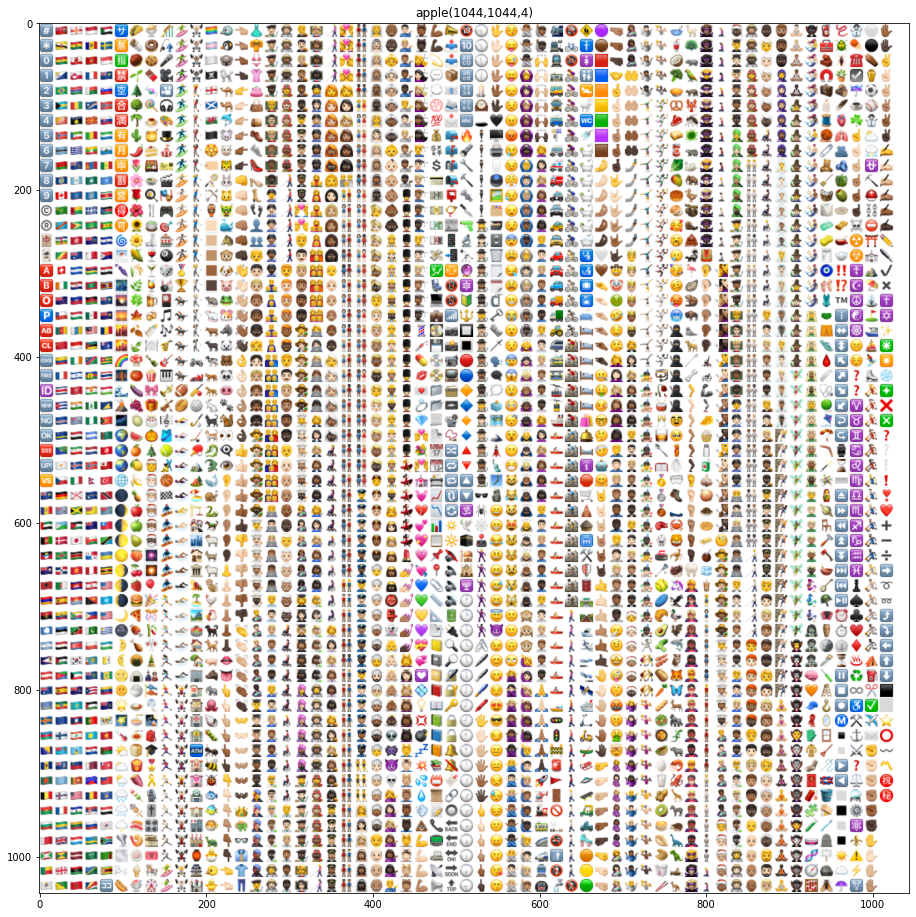

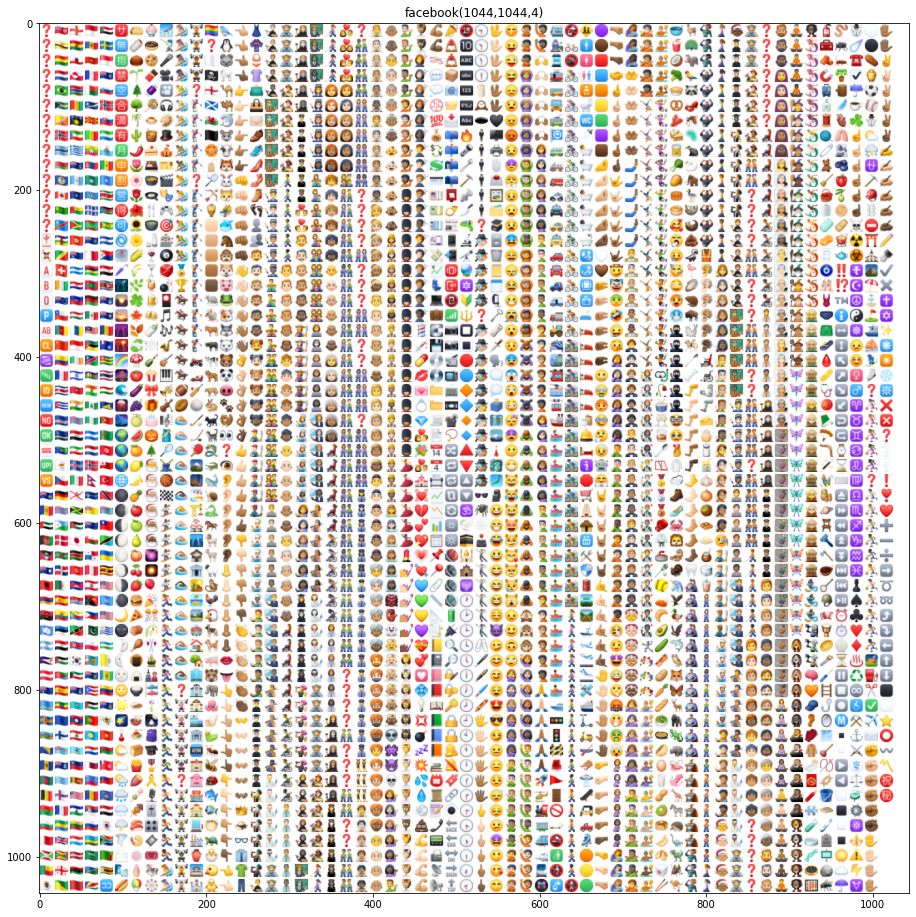

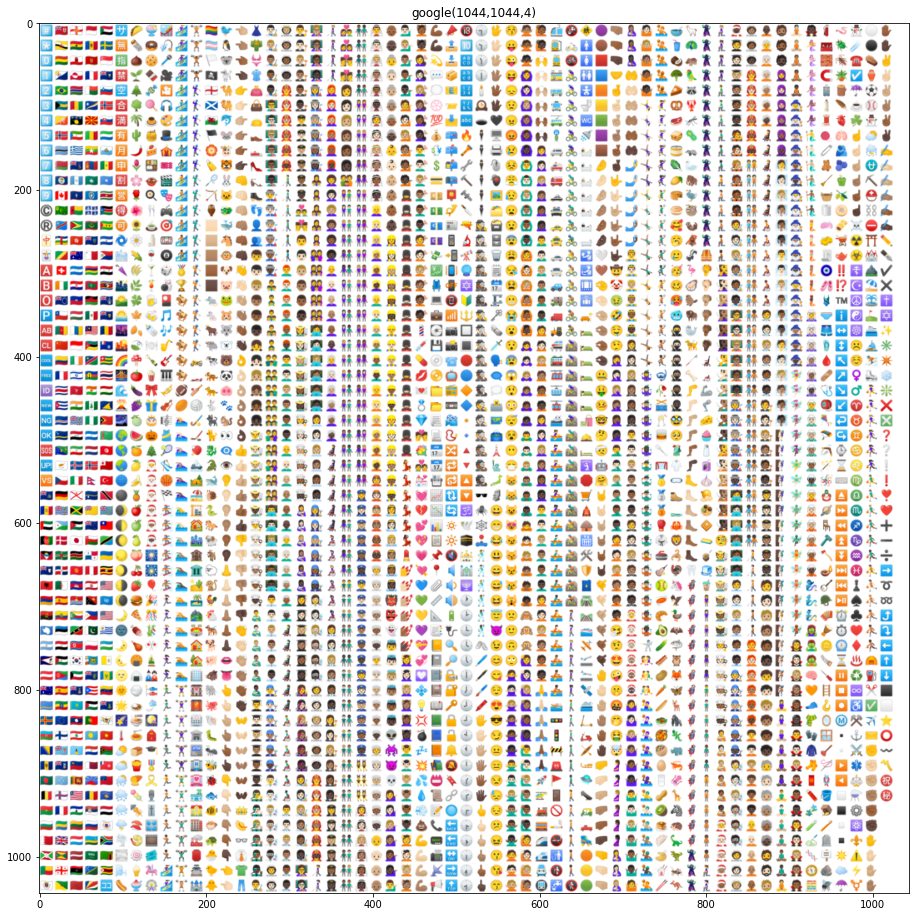

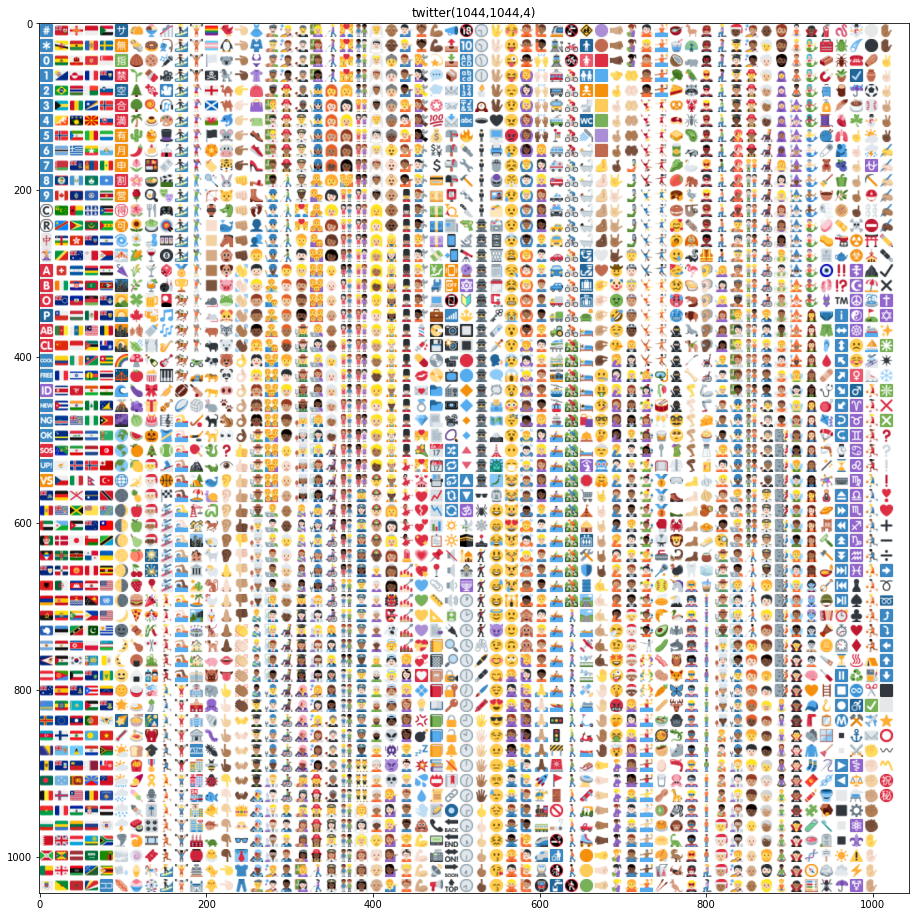

In [7]:
# Your answer here. Aim for 4-6 lines.
for vendor in EMOJI_LIST: 
    plt.figure(figsize=(16,16))
    plt.title("{}({},{},{})".format(vendor,EMOJI_LIST[vendor].shape[0],EMOJI_LIST[vendor].shape[1],EMOJI_LIST[vendor].shape[2]))
    plt.imshow(EMOJI_LIST[vendor])

**Write code** to generate the same four plots as above, except use Numpy slicing to display only the first 3 rows and 8 columns of the sheet. To ensure you do not crop any emojis, take note of any "padding" between the 16x16 emojis in the sheet. Your first plot should look like this, but with the shape numbers (?) and axis ticks filled in:

<img src="img/example-apple-emoji-sheet-slice.png" width=650/>

(If you see a red question mark like <span style="color:red">?</span> for a vendor, it means they do not provide that particular emoji.)

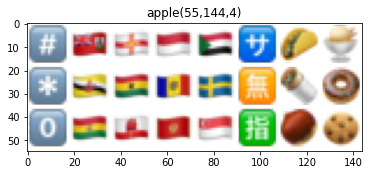

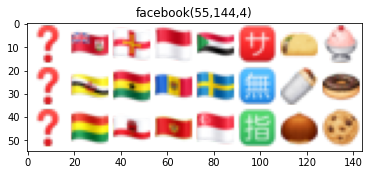

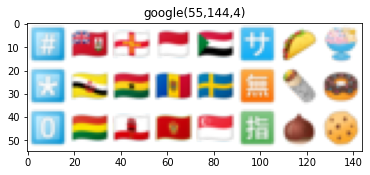

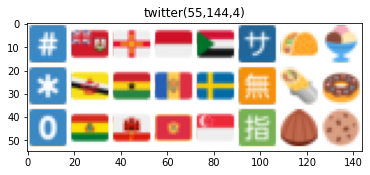

In [8]:
# Your answer here. Aim for 5-9 lines.
for vendor in EMOJI_LIST: 
    sliced_emoji_list = EMOJI_LIST[vendor][0:55,0:144,:]
    plt.figure()
    plt.title("{}({},{},{})".format(vendor, sliced_emoji_list.shape[0],
             sliced_emoji_list.shape[1],
             sliced_emoji_list.shape[2]))
    plt.imshow(sliced_emoji_list)

**Implement *get_emoji_image*.** It should extract a 16x16 RGBA emoji image by its style index (0=*apple*, 1=*facebook*, 2=*google*, 3=*twitter*) and emoji index (as they appear in *emoji.json*). Internally, your function may refer to any global variables you have already defined (metadata, images, size, padding). Use the *sheet_x* and *sheet_y* fields of the metadata. Use slicing and avoid for-loops. <span style="color:#080;font-weight:bold">Briefly comment each line of your code.</span>

In [19]:
#create a dict that contains vendor index
vendor_index = {
    0: "apple", 
    1: "facebook", 
    2: "google",
    3: "twitter"
}
def get_emoji_image(style_index, emoji_index):
    """
    Given a vendor style index (apple=0,facebook=1,google=2,twitter=3)
    and an emoji index, returns the 16x16 RGBA image as a Numpy array
    with shape (16,16,4).
    """
    # Your implementation here. Aim for 5-8 lines (not including comments).
    #Get info of the emoji through index 
    emoji = data[emoji_index]
    sheet_x = emoji["sheet_x"]
    sheet_y = emoji["sheet_y"]
    #After test and trial and do some interpolation I found that: 
    #pixel_begin_index = 18*emoji_index+1 
    #also the sheet_x and sheet_y is somehow reversed 
    x_index = 18*sheet_y +1
    y_index = 18*sheet_x +1
     #We know that the shape of an emoji is 16x16 -> pixel_ending_index = pixel_begin_index + 16
    return EMOJI_LIST[vendor_index[style_index]][x_index:x_index + 16 , y_index:y_index +16]

**Implment *plot_emoji_styles*.** Implement the *plot_emoji_styles* function below, using your *get_emoji_image* function as a subroutine. Use *figsize* to control the size of your figure, use Matplotlib's *subplot* and *title* functions along with its **[suptitle](https://matplotlib.org/3.3.2/api/_as_gen/matplotlib.pyplot.suptitle.html)** to create titles that show the emoji index, the emoji short name, and the vendor title above each style, as shown below:

<img src="img/example-plot-emoji-styles.png" width=600/>

In [20]:
def plot_emoji_styles(emoji_index):
    """Plots all four vendor styles of the given emoji."""
    # Your implementation here. Aim for 6-8 lines.
    plt.figure(figsize=(10,3))
    plt.suptitle("{} {}".format(emoji_index,data[emoji_index]["short_name"]))
    for vendor in vendor_index: 
        plt.subplot(1,4,vendor+1)
        plt.title(vendor_index[vendor])
        plt.imshow(get_emoji_image(vendor, emoji_index))

**Run your *plot_emoji_styles*** function to plot the '*laughing*' emoji from **Q1b**. Also plot two other emojis of your choosing. (Except poop. You're not allowed to plot the poop emoji. Don't you dare. No, no wait stop, have some self-respect, don't do it, noooo!)

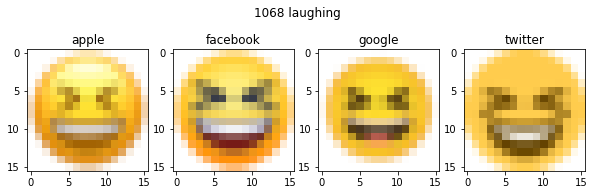

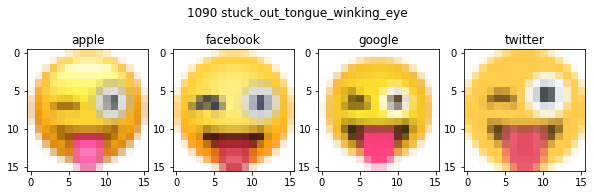

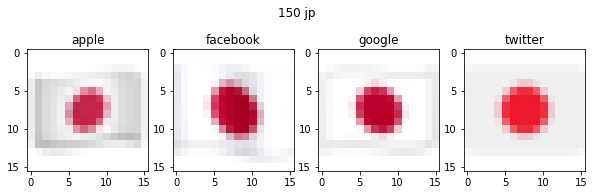

In [23]:
# Your code here. Aim for 2-3 lines.
plot_emoji_styles(1068)
plot_emoji_styles(1090)
plot_emoji_styles(150)

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# Build an emoji data set for machine learning

This question is about converting your list of four raw image sheets into a data set suitable for training with scikit-learn. 

<div style="border-bottom: 1px solid black;"></div>

### Build a set of inputs $\boldsymbol{X}$ from the sheet images 

**Write code** to build a Numpy array of inputs $\boldsymbol{X}$ having dtype *float32* and shape $(N,D)$ where $N$ is the total number of emoji images (number of emojis $\times$ number of vendors) and $D$ is the total number of pixels per emoji (height $\times$ width $\times$ channels). Each image should be converted from RGBA (4 channels) to RGB (3 channels) using the *rgba_to_rgb* function defined at the top of this lab. The first rows of $\boldsymbol{X}$ should all be apple emojis, followed by all facebook emojis, then all google emojis, and finally the last rows should be all twitter emojis. <span style="color:#080;font-weight:bold">Briefly comment each non-trivial line of your code.</span>

In [9]:
# Your answer here. Aim for 6-10 lines.
#Create a list
all_emojis = []
#loop 4 times since there are four vendors
for i in range(4):
    #loop through each emoji in data
    for j in range(len(data)): 
        #append the emoji using get_emoji_image and also convert it to rgb
        all_emojis.append(rgba_to_rgb(get_emoji_image(i, j)).reshape((16*16*3),))
#Convert to np array
X = np.array(all_emojis)
X.shape

NameError: name 'get_emoji_image' is not defined

<div style="border-bottom: 1px solid black;"></div>

### Build a set of targets $\boldsymbol{y}$ from the metadata 

Here you'll enumerate the distinct emoji categories, and then build a vector of integer targets $\boldsymbol{y}$.

**Write code** to get a list of distinct emoji categories, using the *category* field from the metadata; ensure that the list of categories is displayed when the code cell below is executed.

In [26]:
# Your answere here. Aim for 2-4 lines.
set_categories = set()
for emoji in data: 
    set_categories.add(emoji["category"])
categories = list(set_categories)
print(categories)

['Travel & Places', 'Objects', 'Flags', 'Symbols', 'Skin Tones', 'People & Body', 'Food & Drink', 'Activities', 'Smileys & Emotion', 'Animals & Nature']


**Write code** to build a Numpy array of inputs $\boldsymbol{y}$ having dtype *int32* and where $y_i \in \{0, \ldots, M-1\}$ with $M$ being the number of distinct emoji categories. The order of items in $\boldsymbol{y}$ should match those of $\boldsymbol{X}$ from **Q2a**. You may use any approach you like, but potentially useful functions include the *list* object's **[index](https://docs.python.org/3/tutorial/datastructures.html)** function and Numpy's **[np.tile](https://numpy.org/doc/stable/reference/generated/numpy.tile.html)** function. <span style="color:#080;font-weight:bold">Briefly comment each non-trivial line of your code.</span>

In [27]:
# Your answer here. Aim for 3-5 lines.
emoji_categories = [] 
#loop the data four times since there are 4 vendors

for emoji in data: 
    #append the emoji's category
    emoji_categories.append(categories.index(emoji["category"]))
#convert it to numpy arrays
one_vendor_categories = np.array(emoji_categories)
#since there are four vendors we have to multiply it by 4 using np.tile
y = np.tile(one_vendor_categories, 4)
y.shape


(7240,)

**Write code** to demonstrate that, for each $i$ that corresponds to a '*laughing*' emoji (for apple, facebook, google, twitter), its $y_i$ label is set to be the index of the "Smileys & Emotion" category.

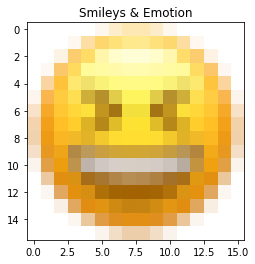

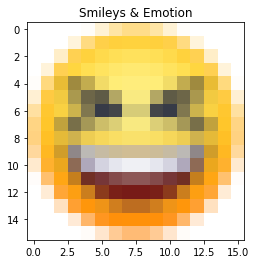

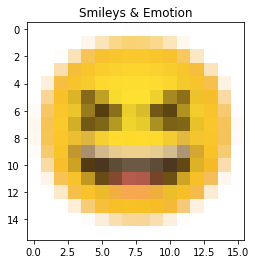

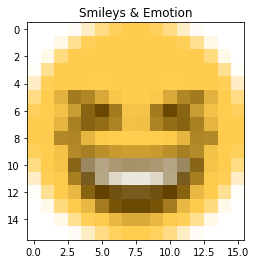

In [28]:
# Your answer here. Aim for 1-3 lines.
for i in range(4):
    plt.figure()
    plt.imshow(X[1068 + i*1810].reshape(16,16,3))
    plt.title(categories[y[1068 + i*1810]])

<div style="border-bottom: 1px solid black;"></div>

### Split and preprocess the data 

**Write code** to randomly split $(\boldsymbol{X}, \boldsymbol{y})$ into three parts, with no overlap:
1. a *training* set $(\boldsymbol{X}_\text{trn}, \boldsymbol{y}_\text{trn})$, which you will use to directly train classifiers
2. a *validation* set $(\boldsymbol{X}_\text{val}, \boldsymbol{y}_\text{val})$, which you will use to estimate the best value for a hyperparameter
3. a *test* set $(\boldsymbol{X}_\text{tst}, \boldsymbol{y}_\text{tst})$, which you will use to evaluate final performance of the 'best' hyperparameters

The training data should comprise 60% of the full data set. The validation and testing data should each comprise 20% of the original data. Use the **[train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)** function and remember to set *random_state* so that your splits (and thereby your conclusions) are reproducible for TAs.

In [29]:
# Your code here. Aim for 2-3 lines.
X_train, X_test_val, y_train, y_test_val = sklearn.model_selection.train_test_split(X,y, test_size=0.4, train_size=0.6, random_state=0)
X_val, X_test, y_val, y_test = sklearn.model_selection.train_test_split(X_test_val,y_test_val, test_size=0.5,train_size=0.5, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)


(4344, 768)
(1448, 768)
(1448, 768)


**Write code** to normalize the features of $\boldsymbol{X}_\text{trn}$, $\boldsymbol{X}_\text{val}$, and $\boldsymbol{X}_\text{tst}$, using scikit-learn's **[StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)**. Be careful which subset of the data you use for estimating the *StandardScaler* object's *scale_* and *mean_* attributes.

In [30]:
# Your answer here. Aim for 4-5 lines.
scaler = sklearn.preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

**Plot a scaled and unscaled emoji side-by-side.** Choose a row from $\boldsymbol{X}_\text{trn}$ and show how it appears as an RGB image with and without scaling. If Matplotlib complains that values are not in range [0,1], consider using **[np.clip](https://numpy.org/doc/stable/reference/generated/numpy.clip.html)**. Your plot should look like the example below, although the choice of emoji could differ.

<img src="img/example-scaled-emoji.png" width=250/>

*Hint:* You do not need to know which row in $\boldsymbol{X}_\text{trn}$ corresponds to which row in $\boldsymbol{X}$. Instead you can "undo" the scaling on whatever row you pick, using one of the methods provided by *StandardScaler*.

Text(0.5, 1.0, 'orginal')

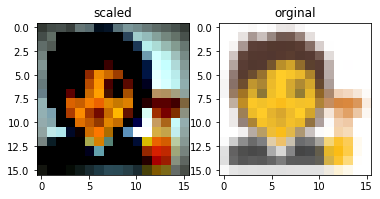

In [32]:
# Your answer here. Aim for 9-12 lines.
plt.figure()
plt.subplot(1,2,1)
plt.imshow(np.clip(X_train[0].reshape(16,16,3),0,1))
plt.title("scaled")
plt.subplot(1,2,2)
plt.imshow(np.clip(scaler.inverse_transform(X_train)[0].reshape(16,16,3),0,1))
plt.title("orginal")


<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# Train classifiers and identify good hyperparameters 

This question has several goals:
1. to help you visualize how hyperparameters affect training/validation/test performance.
2. to give you a sense for how long certain classifiers take to train or to make predictions.
3. to force you to try two useful Python features: (a) passing types as arguments, and (b) argument forwarding.

(However, please take the hyperparameter search lab as a better example of how to use scikit-learn for hyperparameter search; this assignment is focused on making things easy to plot and visualize, not on automating the search itself.)

<div style="border-bottom: 1px solid black;"></div>

### Write a function to trains multiple estimators 

You will be training multiple estimators, each with a different hyperparameter setting.

**Implement the *train_estimators* utility function.** The idea of this function is to make it easy to train multiple versions of an estimator where a single hyperparameter (specified by *param_name*) takes on a different value (specified by *param_vals*) for each estimator. See the docstring below.

*Hint:* For details on how Python argument forwarding works (`**kwargs`), see [this Stack Overflow answer](https://stackoverflow.com/a/36908).

In [33]:
def train_estimators(X, y, estimator_type, param_name, param_vals, **kwargs):
    """
    Trains multiple instances of `estimator_type` on (X, y) by setting argument
    named `param_name` to each value in `param_vals`. Prints a message before
    training each instance. Returns the list of trained estimators.
    
    For example:
    
       >>> train_estimators(X, y, DecisionTreeClassifier, 'max_depth', [1, 5, 10],
                            splitter='random', random_state=0)
    
       Training DecisionTreeClassifier(max_depth=1, random_state=0, splitter='random')...
       Training DecisionTreeClassifier(max_depth=5, random_state=0, splitter='random')...
       Training DecisionTreeClassifier(max_depth=10, random_state=0, splitter='random')...

       [DecisionTreeClassifier(max_depth=1, random_state=0, splitter='random'),
        DecisionTreeClassifier(max_depth=5, random_state=0, splitter='random'),
        DecisionTreeClassifier(max_depth=10, random_state=0, splitter='random')] 
    """
    # Your implementation here. Aim for 5-10 lines.
    
    estimators = [] 
    for i in range(len(param_vals)):
        param_dict = {param_name: param_vals[i]}
        estimator = estimator_type(**param_dict, **kwargs).fit(X,y)
        estimators.append(estimator)
        print("Training {} ...".format(estimator))
    return estimators

**Run the code cell below** to test your implementation of *train_estimators*. (Replace *X_trn* and *y_trn* with whatever you called your training set variables.)

In [34]:
tree_estimators = train_estimators(X_train, y_train, sklearn.tree.DecisionTreeClassifier,
                                   'max_depth', [1, 5, 10], splitter='random', random_state=0)
tree_estimators

Training DecisionTreeClassifier(max_depth=1, random_state=0, splitter='random') ...
Training DecisionTreeClassifier(max_depth=5, random_state=0, splitter='random') ...
Training DecisionTreeClassifier(max_depth=10, random_state=0, splitter='random') ...


[DecisionTreeClassifier(max_depth=1, random_state=0, splitter='random'),
 DecisionTreeClassifier(max_depth=5, random_state=0, splitter='random'),
 DecisionTreeClassifier(max_depth=10, random_state=0, splitter='random')]

<div style="border-bottom: 1px solid black;"></div>

### Train multiples models, plot their accuracies, and identify good parameters 

**Implement the *score_estimators* utility function.** This will be handy for scoring a list of estimators on a particular data set, such as $(\boldsymbol{X}_\text{trn}, \boldsymbol{y}_\text{trn})$. Use the estimator's own *score* method.

In [35]:
def score_estimators(X, y, estimators):
    """Scores each estimator on (X, y), returning a list of scores."""
    # Your implementation here. Aim for 1-4 lines.
    scores = [] 
    for estimator in estimators:
        score = estimator.score(X,y)
        scores.append(score)
    return scores

**Run the code cell below** to test your implementation. It should print three scores per dataset. Each score is a measure of classification accuracy. (Replace *X_trn* and *y_trn* etc with your data set variables.)

In [36]:
print("train:   ", score_estimators(X_train, y_train, tree_estimators))
print("validate:", score_estimators(X_val, y_val, tree_estimators))
print("test:    ", score_estimators(X_test, y_test, tree_estimators))

train:    [0.3031767955801105, 0.5234806629834254, 0.7513812154696132]
validate: [0.305939226519337, 0.5220994475138122, 0.5531767955801105]
test:     [0.324585635359116, 0.5020718232044199, 0.5359116022099447]


**Run the code cell below** to see a demonstration of the `%%time` feature of Jupyter (see [here](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-time)). Note that `%%time` only works if it is the first line in a code cell, before comments.

In [37]:
%%time
for i in range(1000000):  # Burn some CPU cycles in a
    pass                  # loop that does nothing

Wall time: 57.5 ms


**Train multiple *DecisionTreeClassifier*s** on the training set, such that *train_estimators* produces the following output:

    Training DecisionTreeClassifier(max_depth=1, random_state=0, splitter='random')...
    Training DecisionTreeClassifier(max_depth=5, random_state=0, splitter='random')...
    Training DecisionTreeClassifier(max_depth=10, random_state=0, splitter='random')...
    Training DecisionTreeClassifier(max_depth=20, random_state=0, splitter='random')...
    Training DecisionTreeClassifier(max_depth=50, random_state=0, splitter='random')...
    Training DecisionTreeClassifier(max_depth=100, random_state=0, splitter='random')...

In [38]:
%%time
# Your answer here. Aim for 1-2 lines.
tree_estimators = train_estimators(X_train, y_train, sklearn.tree.DecisionTreeClassifier,
                                   'max_depth', [1, 5, 10, 20, 50, 100], splitter='random', random_state=0)

Training DecisionTreeClassifier(max_depth=1, random_state=0, splitter='random') ...
Training DecisionTreeClassifier(max_depth=5, random_state=0, splitter='random') ...
Training DecisionTreeClassifier(max_depth=10, random_state=0, splitter='random') ...
Training DecisionTreeClassifier(max_depth=20, random_state=0, splitter='random') ...
Training DecisionTreeClassifier(max_depth=50, random_state=0, splitter='random') ...
Training DecisionTreeClassifier(max_depth=100, random_state=0, splitter='random') ...
Wall time: 1.62 s


**Implement *plot_estimator_scores*** to visualize the effect of the parameter on accuracy. When applied to the decision tree estimators you trained in the previous cell, the plot should look like below, including legend, colours, marks, and x-axis ticks, but your precise scores may differ depending on how you decided to split the data.

<img src="img/example-decisiontree-scores-plot.png" width=375/>

*Hint:* You can use your *score_estimators* implementation, but do not do any training.

*Hint:* For the title, you can get the object's type from its `__class__` attribute, and you can get the name of its type from the type's `__name__` attribute. Use the first object in *estimators* to determine the name of the classifier type that you're plotting.

*Hint:* If your $x$-axis points are not evenly spaced, you can plot each series using any evenly-spaced $x$ values (e.g. via *np.arange*) and then override the x-axis tick labels with whatever you want. See the *labels* argument of Matplotlib's **[xticks](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.xticks.html)** function.

In [39]:
def plot_estimator_scores(estimators, param_name, param_vals):
    """
    Plots the training, validation, and testing scores of a list of estimators,
    where `param_name` and `param_vals` are the same as for `train_estimators`.
    The estimator with best validation score will be highlighted with an 'x'.
    """
    # Your implementation here. Use as many lines as you need.
    train_scores = score_estimators(X_train, y_train, estimators)
    val_scores = score_estimators(X_val, y_val, estimators)
    test_scores = score_estimators(X_test, y_test, estimators)
    plt.plot(train_scores, label='train', marker='o', color='green')
    plt.plot(val_scores, label='validation', marker='o', color='red')
    plt.plot(test_scores, label='test', color='black', linestyle='dotted')
    plt.scatter(val_scores.index(max(val_scores)), max(val_scores),s=200, color='red', marker='x')
    plt.xlabel(param_name)
    plt.ylabel("score")
    plt.title(type(estimators[0]).__name__ + " score vs " + param_name)
    plt.xticks(np.arange(len(param_vals)),param_vals)
    plt.ylim(0.0,1.1)
    plt.text(3, 0.4 ,"train = %.3f" % (max(train_scores)), color='green')
    plt.text(3, 0.3, "validate = %.3f" % (max(val_scores)), color='red')
    plt.text(3, 0.2, "test = %.3f" % (max(test_scores)))
    plt.legend()
    difference = abs(max(val_scores) - test_scores[val_scores.index(max(val_scores))])
    print("test and val difference = {}".format(difference))
        

**Plot the *DecisionTreeClassifier* scores** by calling your *plot_estimator_scores* function. Your plot should look like the example plot.

test and val difference = 0.017265193370165743
Wall time: 62 ms


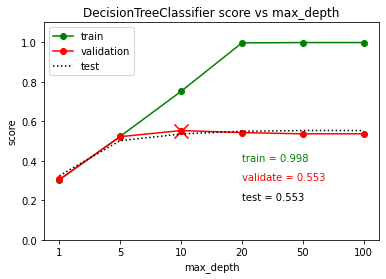

In [40]:
%%time
# Your code here. Aim for 1 line.
plot_estimator_scores(tree_estimators, 'max_depth', [1, 5, 10, 20, 50, 100])

**Train multiple *RandomForestClassifiers*** such that *train_estimators* produces the following output:

    Training RandomForestClassifier(max_depth=1, random_state=0)...
    Training RandomForestClassifier(max_depth=5, random_state=0)...
    Training RandomForestClassifier(max_depth=10, random_state=0)...
    Training RandomForestClassifier(max_depth=20, random_state=0)...
    Training RandomForestClassifier(max_depth=50, random_state=0)...
    Training RandomForestClassifier(max_depth=100, random_state=0)...

In [41]:
%%time
# Your code here. Aim for 1-2 lines.
random_forest_estimators = train_estimators(X_train, y_train, sklearn.ensemble.RandomForestClassifier, 
                                            'max_depth', [1,5,10,20,50,100], random_state=0)

Training RandomForestClassifier(max_depth=1, random_state=0) ...
Training RandomForestClassifier(max_depth=5, random_state=0) ...
Training RandomForestClassifier(max_depth=10, random_state=0) ...
Training RandomForestClassifier(max_depth=20, random_state=0) ...
Training RandomForestClassifier(max_depth=50, random_state=0) ...
Training RandomForestClassifier(max_depth=100, random_state=0) ...
Wall time: 23.8 s


**Plot the *RandomForestClassifier* scores**, again by calling your *plot_estimator_scores* function.

test and val difference = 0.0006906077348066697
Wall time: 848 ms


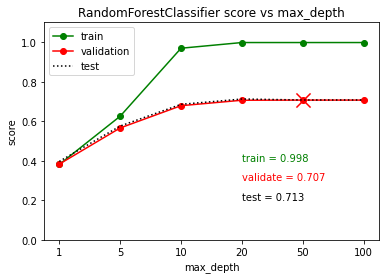

In [42]:
%%time
# Your code here. Aim for 1 line.
plot_estimator_scores(random_forest_estimators, 'max_depth', [1, 5, 10, 20, 50, 100])

**Train multiple *LogisticRegression* classifiers** such that *train_estimators* produces the following output:

    Training LogisticRegression(C=1e-05, max_iter=10000, random_state=0)...
    Training LogisticRegression(C=0.0001, max_iter=10000, random_state=0)...
    Training LogisticRegression(C=0.001, max_iter=10000, random_state=0)...
    Training LogisticRegression(C=0.01, max_iter=10000, random_state=0)...
    Training LogisticRegression(C=0.1, max_iter=10000, random_state=0)...
    Training LogisticRegression(max_iter=10000, random_state=0)...
    
The omission of *C* when the final estimator was printed means it was trained with its default value, which is *C*=1. You can try it yourself:
```python
>>> LogisticRegression(C=1.01)
LogisticRegression(C=1.01)

>>> LogisticRegression(C=1.0)
LogisticRegression()
```

In [43]:
%%time
# Your code here. Aim for 1-2 lines
logistic_regression_estimators = train_estimators(X_train, y_train, sklearn.linear_model.LogisticRegression, 
                                            'C', [1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0], max_iter=10000, random_state=0)

Training LogisticRegression(C=1e-05, max_iter=10000, random_state=0) ...
Training LogisticRegression(C=0.0001, max_iter=10000, random_state=0) ...
Training LogisticRegression(C=0.001, max_iter=10000, random_state=0) ...
Training LogisticRegression(C=0.01, max_iter=10000, random_state=0) ...
Training LogisticRegression(C=0.1, max_iter=10000, random_state=0) ...
Training LogisticRegression(max_iter=10000, random_state=0) ...
Wall time: 24.4 s


**Plot the *LogisticRegression* scores**, again by calling your *plot_estimator_scores* function.

test and val difference = 0.006215469613259694
Wall time: 162 ms


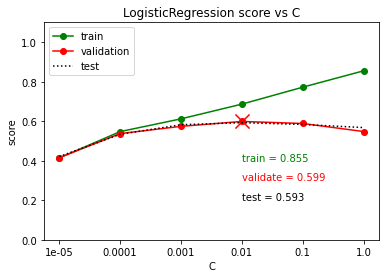

In [44]:
%%time
# Your code here. Aim for 1 line.
plot_estimator_scores(logistic_regression_estimators, 'C', [1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0])

**Train multiple SVM classifiers (*SVC*)** such that *train_estimators* produces the following output:

    Training SVC(C=0.01, gamma=0.001, max_iter=10000, random_state=0)...
    Training SVC(C=0.1, gamma=0.001, max_iter=10000, random_state=0)...
    Training SVC(gamma=0.001, max_iter=10000, random_state=0)...
    Training SVC(C=10.0, gamma=0.001, max_iter=10000, random_state=0)...
    Training SVC(C=100.0, gamma=0.001, max_iter=10000, random_state=0)...
    Training SVC(C=1000.0, gamma=0.001, max_iter=10000, random_state=0)...

In [45]:
%%time
# Your code here. Aim for 1-2 lines.
svm_estimators = train_estimators(X_train, y_train, sklearn.svm.SVC,'C',
                                  [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], gamma=0.001, max_iter=10000, random_state=0)

Training SVC(C=0.01, gamma=0.001, max_iter=10000, random_state=0) ...
Training SVC(C=0.1, gamma=0.001, max_iter=10000, random_state=0) ...
Training SVC(gamma=0.001, max_iter=10000, random_state=0) ...
Training SVC(C=10.0, gamma=0.001, max_iter=10000, random_state=0) ...
Training SVC(C=100.0, gamma=0.001, max_iter=10000, random_state=0) ...
Training SVC(C=1000.0, gamma=0.001, max_iter=10000, random_state=0) ...
Wall time: 1min 7s


**Plot the *SVM* scores**, again by calling your *plot_estimator_scores* function. Predictions may take several minutes to compute.

test and val difference = 0.008287292817679592
Wall time: 1min 34s


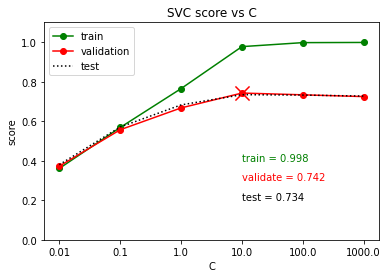

In [46]:
%%time
# Your code here. Aim for 1 line.
plot_estimator_scores(svm_estimators, 'C', [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0])

**Question.** Do your plots support the claim that "validation set performance" is a good estimate of "test set performance" overall? YES/NO then explain below.

**Question.** Which of your classifiers had the highest test-set performance for its "best" configuration (i.e., for the configuration with highest validation-set performance)? Name the classifier and best hyperparameter setting (*max_depth* or *C*).

**Question.** Which of your classifiers had the *least over-fitting*, if we measured overfitting as the absolute difference between training-set and testing-set performance? Name the classifier and hyperparameter setting (*max_depth* or *C*).

**Question.** Which if your classifiers was slowest to train? Name the classifier.

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# Visualizing mistakes 

The goal here is to visualize classification errors, by confusion matrix and by inspecting typical mistakes.

<div style="border-bottom: 1px solid black;"></div>

### *Q4a &mdash;  Plot a confusion matrix for the best estimators [5 marks]*

**Write code** to plot a confusion matrix for each of the 'best' estimators in **Q3** when applied to test set $(\boldsymbol{X}_\text{tst}, \boldsymbol{y}_\text{tst})$. Here, 'best' means best validation score. All estimators are already trained, so you can simply pull out the one best of each type {tree, forest, logistic, svm}. Use **[plot_confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html)**. Your first plot should look like as below, though the numbers may differ.

<img src="img/example-decisiontree-confusion-matrix.png" width="350"/>

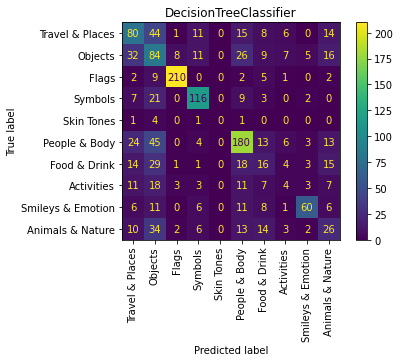

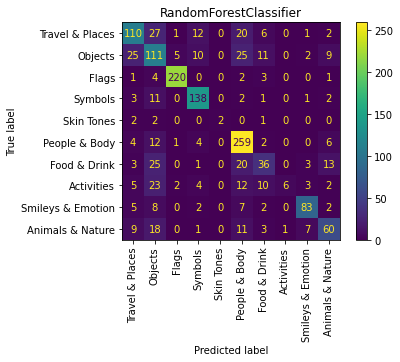

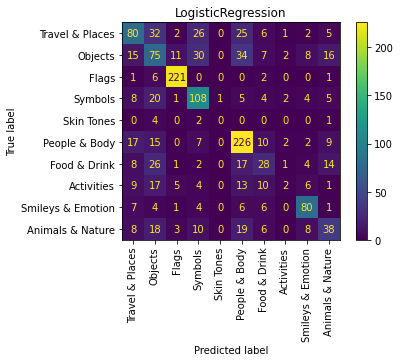

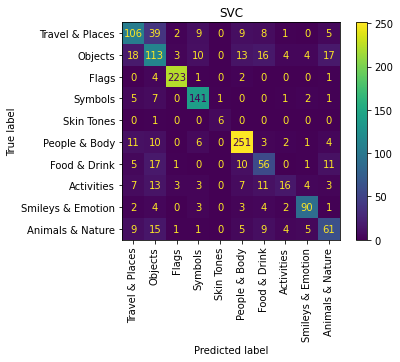

In [47]:
# # Your answer here. Aim for 7-12 lines.
ALL_ESTIMATORS = [tree_estimators, random_forest_estimators, logistic_regression_estimators, svm_estimators]
for estimators in ALL_ESTIMATORS: 
    validation_scores = score_estimators(X_val,y_val, estimators)
    best_estimator = estimators[validation_scores.index(max(validation_scores))]
    matrix = sklearn.metrics.plot_confusion_matrix(best_estimator, X_test,y_test, xticks_rotation='vertical',
                                          display_labels=categories)
    matrix.ax_.set_title(type(best_estimator).__name__)
    plt.show()

**Question.** What classifier is best at distinguishing between the *Flags* class and the *Objects* class, overall? Name the classifier and justify your choice.

<div style="border-bottom: 1px solid black;"></div>

### Identify specific misclassified examples 

In this question, us the "best performing" classifier that you named at the end of **Q4a**.

**Write code** to identify all "*Objects* misclassified as *Flags*" from the test-set and then plot them as images. (The phrase "*A* misclassified as *B*" means the prediction was *B* but the true class was *A*.) Your code for identifying the misclassified examples should be vectorized, for example using functions like *np.logical_and* and/or *np.nonzero*. (Remember you might need to "undo" the feature normalization like in **Q2c**).

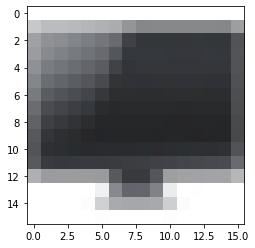

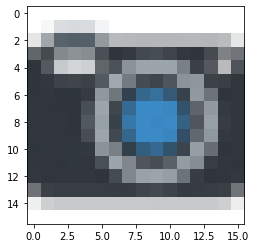

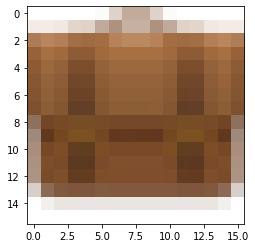

In [48]:
# Your answer here. Aim for 7-12 lines.
validation_scores = score_estimators(X_val,y_val, svm_estimators)
best_estimator = svm_estimators[validation_scores.index(max(validation_scores))]
y_pred = best_estimator.predict(X_test)
misclassified = np.logical_and(y_test==categories.index("Objects"), y_pred==categories.index("Flags"))
X_misclassified = X_test[misclassified]
for i in range(X_misclassified.shape[0]):
    plt.figure()
    plt.imshow(np.clip(scaler.inverse_transform(X_misclassified)[i].reshape(16,16,3),0,1))

**Question.** After seeing the failure cases above, can you guess why the estimator is confusing them with *Flags*? Explain in 1-2 sentences.

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# Visualizing feature importances 

The goal here is to visualize sensitivity to specific input features.

<div style="border-bottom: 1px solid black;"></div>

### Visualize the feature importances of a RandomForestClassifier

**Implement *plot_random_forest_importances*** below. This function should plot the *feature_importances_* attribute of a *RandomForestClassifier* (see scikit-learn docs). For the random forests you trained, there are $16 \times 16 \times 3$ features, so to make visualization easy the feature importances should be organized into three separate side-by-side heatmaps: one for each RGB colour channel. When plotting a heatmap, use *cmap*='cool' to choose the colour map. For example, plotting the feature importances of a random forest with *max_depth*=1 should look something like this:

<img src="img/example-random-forest-feature-importances.png" width="350"/>

In [49]:
def plot_random_forest_importances(estimator):
    """
    Plots the feature importances of the given RandomForestClassifier,
    arranged as three separate 16x16 heatmaps for (red, green, blue).
    """
    # Your implementation here. Aim for 7-10 lines.
    plt.figure(figsize = (10,10))
    color_dict = {0 : 'R', 1 :'G' , 2 : 'B'}
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.title(color_dict[i])
        plt.imshow(estimator.feature_importances_.reshape(16,16,3)[:,:,i], cmap='cool')
        plt.axis('off')

**Check your code** by calling your function to plot the feature importances of first *RandomForestClassifier* that you trained (with *max_depth*=1).

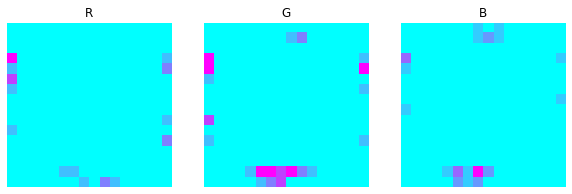

In [50]:
# Your code here (1 line)
plot_random_forest_importances(random_forest_estimators[0])


**Plot the feature importances** of your 'best' *RandomForestClassifier* instance. The patterns should be more complex.

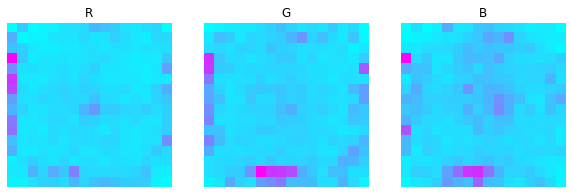

In [51]:
# Your code here (1 line)
plot_random_forest_importances(random_forest_estimators[3])

**Question.** Why do you think the features near the edge of the image so 'important'? Explain in 1-2 sentences.

<div style="border-bottom: 1px solid black;"></div>

### Visualize the feature weights of LogisticRegression

This question is essentially the same as **Q5a** except you will extract the per-class weights of a *LogisticRegression* estimator that was trained on emoji images.

**Implement *plot_logistic_weights*** so that for each of the 10 categories of emoji it plots three side-by-side images.  Use the *coef_* attribute of *LogisticRegression* to extract the $16 \times 16 \times 3$ weights for each category, and then generate a separate heatmap for each RGB channel. Since we want to see clearly which weights are positive or negative, use *cmap*='bwr' when plotting each heatmap. Use *suptitle* to label each group of heatmaps with its category label. Your function should generate $10 \times 3$ heatmaps total. Below are examples of 2 of the 10 possible rows:

<img src="img/example-logistic-weights-regularized-animals.png" width="325"/>
<img src="img/example-logistic-weights-regularized-smileys.png" width="325"/>

*Hint:* Note that the $i^\text{th}$ set of weights may not match the order of categories. Use the *classes_* attribute of *LogisticRegression* to recover the category index.

In [52]:
def plot_logistic_weights(estimator):
    """
    Plots heatmaps showing the weights of the LogisticRegression estimator,
    with a separate plot for each class and for each colour channel.
    """
    assert isinstance(estimator, sklearn.linear_model.LogisticRegression)
    # Your implementation here here. Aim for 9-12 lines.
    color_dict = {0 : 'R', 1 :'G' , 2 : 'B'}
    for i in range(len(estimator.classes_)):
        plt.figure(figsize=(10,4))
        plt.suptitle(categories[estimator.classes_[i]])
        for j in range(3):
            plt.subplot(1,3,j+1)
            plt.title(color_dict[j])
            plt.imshow(estimator.coef_[i].reshape(16,16,3)[:,:,j],cmap='bwr')
            plt.axis('off')

**Check your code** by calling your function to plot the weights of the *LogisticRegression* classifier having *strongest* regularization (the one with *C*=1e-5).

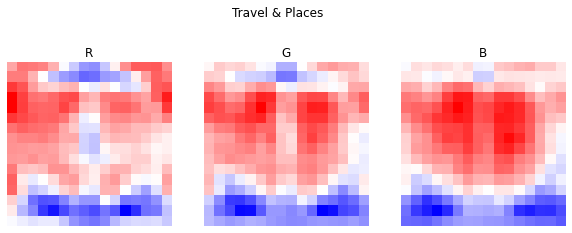

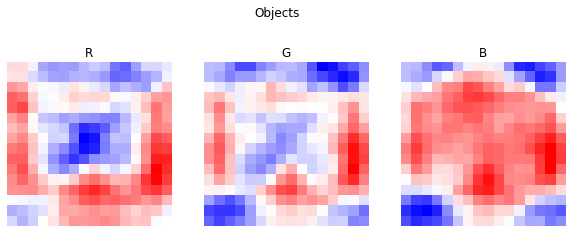

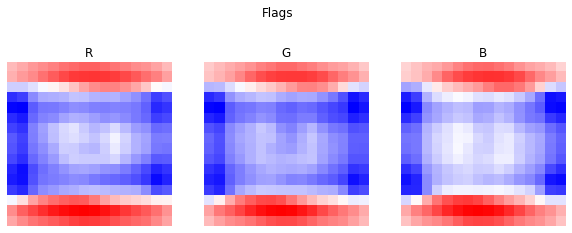

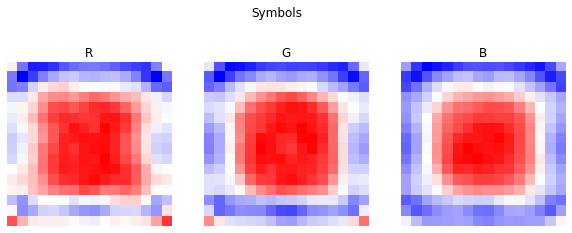

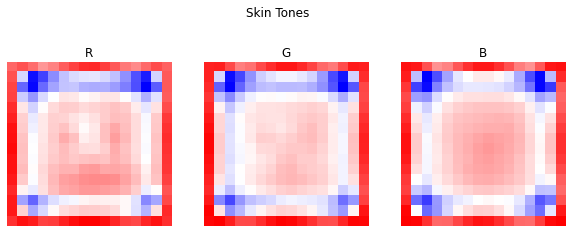

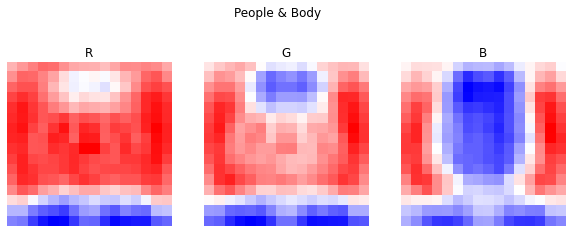

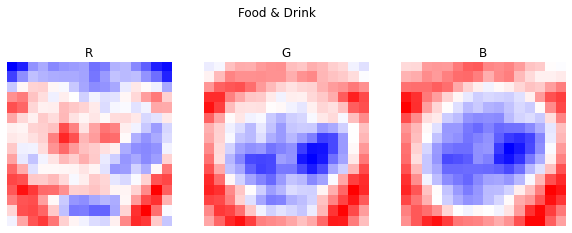

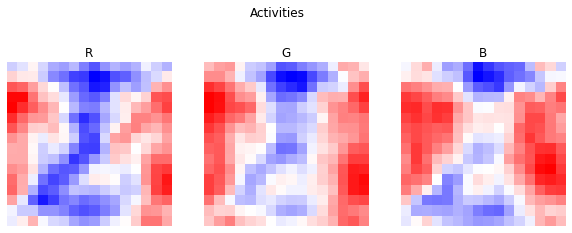

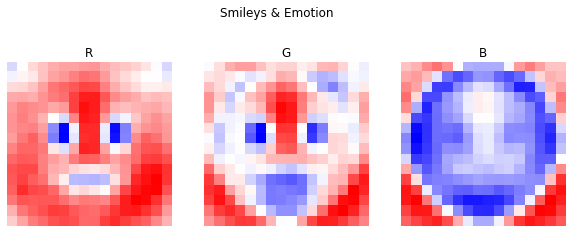

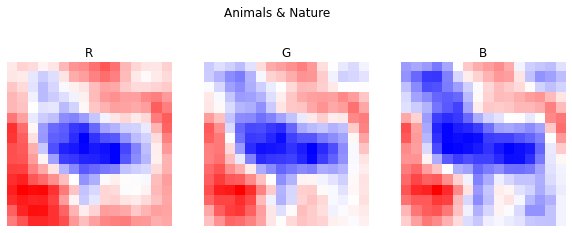

In [53]:
# Your code here (1 line)
plot_logistic_weights(logistic_regression_estimators[0])

**Plot the weights** of your 'best' *LogisticRegression* instance.

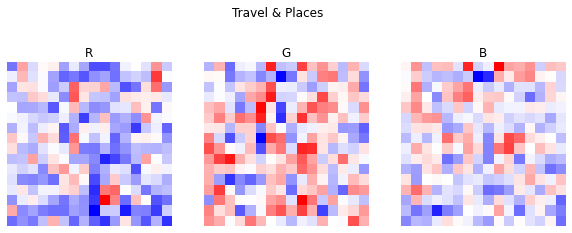

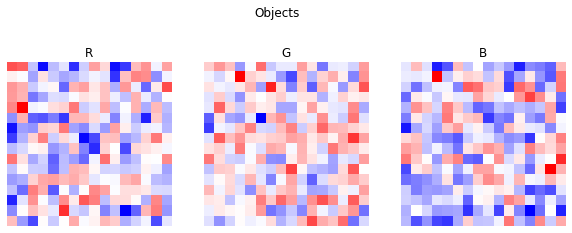

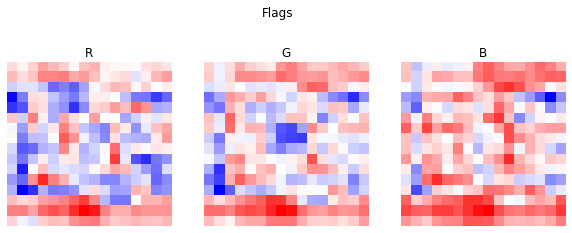

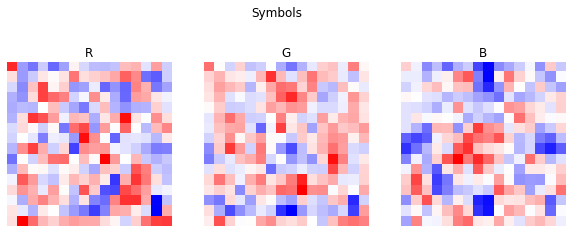

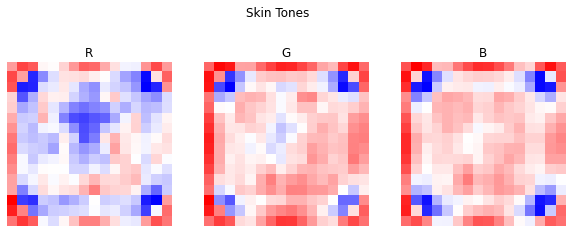

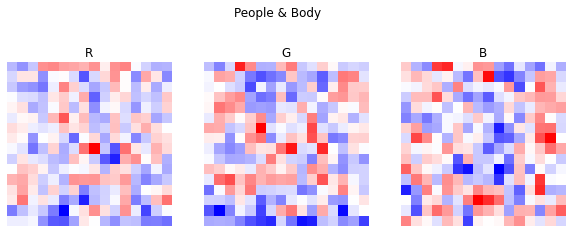

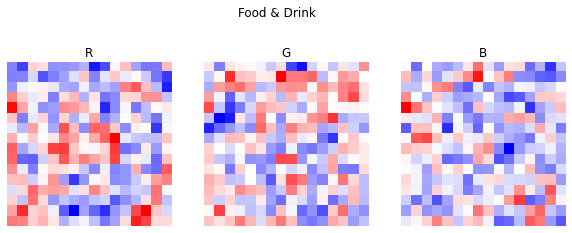

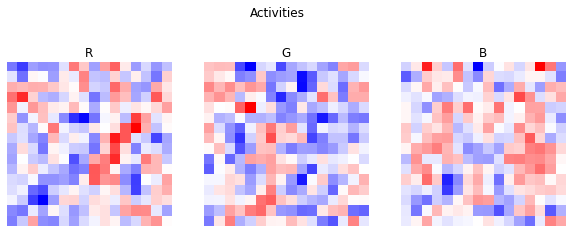

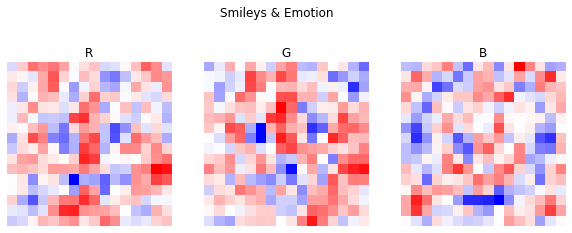

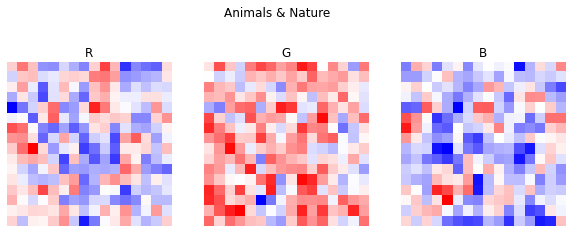

In [54]:
# Your code here (1 line)
plot_logistic_weights(logistic_regression_estimators[3])

**Question.** Was your best-performing *LogisiticRegression* classifier also the most interpretable? YES/NO then explain in 2-3 sentences.

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# Generating Python code for a tree  

The goal here is to develop a deeper understanding of scikit-learn's decision tree and data structure, by generating an equivalent Python program, compiling it, and executing it. Most of the question is just learning how things work, and the part you have to do is at the very end.

**Run the code cell below**, replacing *X_trn* and *y_trn* with whatever you named your training set variables.

true: [5 1 6 2]
pred: [5 1 6 1]
2


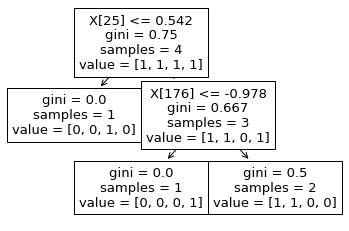

In [55]:
# Train a tiny tree on a tiny training set of only 4 instances
X_tiny = X_train[:4]
y_tiny = y_train[:4]
tiny_tree = sklearn.tree.DecisionTreeClassifier(max_depth=2, random_state=0).fit(X_tiny, y_tiny)

# Plot the tree and print the true and predicted labels
sklearn.tree.plot_tree(tiny_tree)
print("true:", y_tiny)
print("pred:", tiny_tree.predict(X_tiny))
print(tiny_tree.get_depth())

The above is meant as a simple easy-to-understand tree, much simpler than the real ones you trained in **Q3**.

**Run the code cell below** to see a function that traverses a *DecisionTreeClassifier*'s internal tree data structure and prints a message each time it encounters a split node or a leaf node. Notice how it corresponds to the plotted tree above.

In [56]:
def print_tree(tree):
    """Prints the structure of a DecisionTreeClassifier."""
    assert isinstance(tree, sklearn.tree.DecisionTreeClassifier)

    # Shorthand for some tree attributes
    left = tree.tree_.children_left     # left[i]: index of left  node when i is a split
    right = tree.tree_.children_right   # right[i]: index of right node when i is a split
    feature = tree.tree_.feature        # feature[i]: index feature to test when i is a split
    threshold = tree.tree_.threshold    # threshold[i]: threshold to use when i is a split
    votes = tree.tree_.value            # votes[i,j]: number of training examples to reach
                                        #             node i while having class index j
    def visit_subtree(i, depth):
        indent = "  "*depth
        if left[i] != right[i]:
            print("%snode %d: split on x[%d] <= %f" % (indent, i, feature[i], threshold[i]))
            visit_subtree(left[i],  depth+1)
            visit_subtree(right[i], depth+1)
        else:
            label = tree.classes_[np.argmax(votes[i])]
            print("%snode %d: leaf label %d" % (indent, i, label))
            
    visit_subtree(0, 0)
    
print_tree(tiny_tree)

node 0: split on x[25] <= 0.541913
  node 1: leaf label 5
  node 2: split on x[176] <= -0.977530
    node 3: leaf label 6
    node 4: leaf label 1


**Call *print_tree* on your best *DecisionTreeClassifier*** from **Q3**. (The output will be very long.)

In [57]:
# Your code here (1 line)
print_tree(tree_estimators[3])

node 0: split on x[193] <= 0.281792
  node 1: split on x[742] <= 0.773857
    node 2: split on x[532] <= -0.059167
      node 3: split on x[619] <= -0.135204
        node 4: split on x[311] <= 0.463921
          node 5: split on x[131] <= -0.630238
            node 6: split on x[686] <= -1.243356
              node 7: split on x[71] <= -0.350052
                node 8: split on x[10] <= 0.329462
                  node 9: split on x[522] <= 0.224835
                    node 10: split on x[168] <= -0.575970
                      node 11: split on x[425] <= 0.408715
                        node 12: split on x[240] <= 0.228530
                          node 13: split on x[305] <= 0.793287
                            node 14: split on x[104] <= -2.078035
                              node 15: split on x[187] <= -1.671061
                                node 16: leaf label 3
                                node 17: leaf label 4
                              node 18: leaf label 3
            

                        node 369: leaf label 2
                node 370: split on x[515] <= 0.955706
                  node 371: leaf label 2
                  node 372: split on x[586] <= -0.532684
                    node 373: leaf label 2
                    node 374: leaf label 1
              node 375: split on x[261] <= 0.375164
                node 376: leaf label 1
                node 377: leaf label 2
            node 378: split on x[90] <= 0.377274
              node 379: split on x[667] <= 0.197829
                node 380: split on x[371] <= 0.438433
                  node 381: leaf label 8
                  node 382: leaf label 1
                node 383: split on x[172] <= 0.861539
                  node 384: leaf label 2
                  node 385: leaf label 6
              node 386: split on x[111] <= 0.746814
                node 387: split on x[79] <= 0.712206
                  node 388: leaf label 1
                  node 389: split on x[695] <= 0.841688
          

**Implement the *tree_to_code* function below.** The idea is to transform a *DecisionTreeClassifier* instance into equivalent Python code, where the code is built up as a string. You may copy whatever code you want from *print_tree* as a starting point, but you must <span style="color:#080;font-weight:bold">add a comment for each new line of code</span>.

For example, if you called it with the *tiny_tree* from earlier, it might produce a string like below (although not necessarily an identical program, depending on the training set for *tiny_tree*).

```
>>> print(tree_to_code(tiny_tree))
def predict(x):
  if x[395] <= -0.642489:
    if x[174] <= -0.988780:
      return 4
    else:
      return 7
  else:
    return 0
```

In [58]:
def tree_to_code(tree):
    """
    Given a *DecisionTreeClassifier*, returns a string that
    defines a Python function that corresponds to how the
    decision tree makes predictions. The first line of the
    string is:
    
         "def predict(x):\n..."
         
    followed by lines of code for the logic of the tree.
    """
    # Your implementation here.
    left = tree.tree_.children_left     # left[i]: index of left  node when i is a split
    right = tree.tree_.children_right   # right[i]: index of right node when i is a split
    feature = tree.tree_.feature        # feature[i]: index feature to test when i is a split
    threshold = tree.tree_.threshold    # threshold[i]: threshold to use when i is a split
    votes = tree.tree_.value            # votes[i,j]: number of training examples to reach
                                        #             node i while having class index j
    #first line of code 
    code ="def predict(x):\n"
    #Define a recursion method to traverse the tree
    def visit_subtree(i, depth):
        code = ''
        #for Python tab indentation
        indent = "\t"*(depth+1)
        #If there is a split
        if left[i] != right[i]:
            #The condition 
            code += "{}if x[{}] <= {}:\n".format(indent, feature[i], threshold[i])
            #If it statisfies the first condition, traverse the subtrees of that branch
            code += visit_subtree(left[i],  depth+1)
            #else
            code += "{}else:\n".format(indent)
            #traverse the subtrees of the other branch
            code += visit_subtree(right[i], depth+1)
        else:
            #if theres no split then return the value
            label = tree.classes_[np.argmax(votes[i])]
            code += "{}return {}\n".format(indent, label)
        #return the code string after finish traversing
        return code
    return code + visit_subtree(0, 0)

**Run the code cell below** to check your implementation. You should see a program equivalent to the tiny decision tree you plotted earlier.

In [59]:
print(tree_to_code(tiny_tree))

def predict(x):
	if x[25] <= 0.5419127196073532:
		return 5
	else:
		if x[176] <= -0.9775299727916718:
			return 6
		else:
			return 1



**Run the code cell below** to define a utility function called *compile_func*. What this function does is it takes a string containing a single Python function definition, and compiles it, returning a *function* object that can be called to execute the code represented by the string.

In [60]:
def compile_func(python_code):
    """
    Compiles a string defining a Python function, and returns
    a reference to the callable function object that results.
    """
    symbols = {}                             # Dictionary to collect symbols that get defined.
    exec(python_code, None, symbols)         # Execute the string as if it were code.
    assert len(symbols) == 1, "Expected python_code to define a function"
    function = next(iter(symbols.values()))  # Get reference to the object that was defined.
    assert callable(function), "Expected python_code to define a function"
    return function

**Run the code cell below** to see a demo of how *compile_func* works.

In [61]:
example_code = """
def square(x):
    return x**2
"""

example_func = compile_func(example_code)
print(example_func)

for i in range(5):
    print(example_func(i))

<function square at 0x24E01B68>
0
1
4
9
16


**Write code** to (a) convert your best *DecisionTreeClassifier* to a compiled Python function and (b) assert that the compiled Python function produces the same predictions on the training set $\boldsymbol{X}_\text{trn}$. (Note that your Python function expects a 1-dimensional $\boldsymbol{x}$, whereas *DecisionTreeClassifier* expects a 2-dimensional $\boldsymbol{X}$.)

In [62]:
# Your answer here. Aim for 2-4 lines.

tree_func = compile_func(tree_to_code(tree_estimators[3]))
y_pred = tree_estimators[3].predict(X_train)
y_code_pred = []
for x in X_train: 
    y_code_pred.append(tree_func(x))
assert np.array_equal(np.array(y_code_pred),y_pred)
print("looking gooooood")

looking gooooood


**Write code to compare the prediction speed** of your *DecisionTreeClassifer* instance versus your pure-Python function. Specifically, you should use `%%time` to report the amount of time that *DecisionTreeClassifer* takes to generate predictions on the training set $\boldsymbol{X}_\text{trn}$.

In [63]:
%%time
# Your code for timing your best DecisionTreeClassifier here. Aim for 1 line.
y_pred = tree_estimators[3].predict(X_train)

Wall time: 3.97 ms


In [64]:
%%time
# Your code for timing the Python version here. Aim for 1-2 lines.
y_code_pred = []
for x in X_train: 
    y_code_pred.append(tree_func(x))

Wall time: 99.1 ms


**Question.** Which version was faster and by how much? What do you think explains this?